<a href="https://colab.research.google.com/github/LC-Platform/multimodal-Concept-accessor/blob/Domain-keyword-identifier/TF_IDF_Model_Performance_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 2 Development

CODE 1

In [ ]:
import nltk
import fitz
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import Counter
import numpy as np

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

def extract_text_from_pdf(path):
    doc = fitz.open(path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    doc.close()
    return full_text

lemmatizer = WordNetLemmatizer()

def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    return " ".join([lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2])

def extract_pmi_phrases(text, top_n=50, pmi_threshold=5, min_freq=2):
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stopwords.words("english") and len(w) > 2]
    if len(words) < 2:
        return []
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(min_freq)
    acceptable_bigrams = [
        bigram for bigram in finder.ngram_fd
        if all(word not in stopwords.words("english") and len(word) > 2 for word in bigram)
    ]
    finder.ngram_fd = Counter({bg: finder.ngram_fd[bg] for bg in acceptable_bigrams})
    if not finder.ngram_fd:
        return []
    try:
        scored = finder.score_ngrams(BigramAssocMeasures.pmi)
    except ValueError as e:
        return []
    pmi_phrases = [' '.join(bigram) for bigram, score in scored if score >= pmi_threshold]
    return pmi_phrases[:top_n]

def replace_phrases(text, phrases):
    phrases_sorted = sorted(phrases, key=lambda x: -len(x.split()))
    processed_text = text
    for phrase in phrases_sorted:
        escaped = re.escape(phrase)
        pattern = r'\b' + escaped.replace(' ', r'\s+') + r'\b'
        processed_text = re.sub(pattern, phrase.replace(" ", "_"), processed_text)
    return processed_text

def extract_tfidf_keywords(text, top_n=30, tfidf_threshold=0.1, ngram_range=(1, 3)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform([text])
    if X.shape[1] == 0:
        return []
    features = vectorizer.get_feature_names_out()
    scores = X.toarray()[0]
    tfidf_keywords = [(features[i], scores[i]) for i in range(len(features))]
    sorted_keywords = sorted(tfidf_keywords, key=lambda x: x[1], reverse=True)
    final_keywords = [(kw, score) for kw, score in sorted_keywords if score >= tfidf_threshold][:top_n]
    return [kw.replace('_', ' ') for kw, score in final_keywords]

def evaluate_flexible(predicted, truth):
    def normalize_kw(kw):
        kw = re.sub(r'[^\w\s]', '', kw).lower().strip()
        return kw
    pred_set = set(normalize_kw(k) for k in predicted if normalize_kw(k))
    true_set = set(normalize_kw(k) for k in truth if normalize_kw(k))
    matched_true = set()
    matched_pred = set()
    for t in true_set:
        for p in pred_set:
            if t in p or p in t:
                matched_true.add(t)
                matched_pred.add(p)
    true_positives = len(matched_true)
    false_positives = len(pred_set - matched_pred)
    false_negatives = len(true_set - matched_true)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    all_terms = sorted(list(pred_set | true_set))
    y_true_binary = [1 if normalize_kw(kw) in true_set else 0 for kw in all_terms]
    y_pred_binary = [1 if normalize_kw(kw) in pred_set else 0 for kw in all_terms]
    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

PMI_THRESHOLD = 4
TFIDF_THRESHOLD = 0.05
TOP_N_PMI = 100
TOP_N_TFIDF = 100
MIN_PMI_FREQ = 2
TFIDF_NGRAM_RANGE = (1, 3)

pdf_path = "/content/Class-XI-Biology.pdf"
manual_keyword_path = "/content/Chapter3_biology_keywords.txt"

def load_manual_keywords(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.strip("- \n") for line in f if line.strip()]
    lemmatizer = WordNetLemmatizer()
    return [" ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(line.lower())]) for line in lines]

raw_text = extract_text_from_pdf(pdf_path)
cleaned_text = normalize(raw_text)
pmi_phrases = extract_pmi_phrases(cleaned_text, top_n=TOP_N_PMI, pmi_threshold=PMI_THRESHOLD, min_freq=MIN_PMI_FREQ)
print(f"Extracted {len(pmi_phrases)} PMI phrases.")
enhanced_text = replace_phrases(cleaned_text, pmi_phrases)
tfidf_keywords_enhanced = extract_tfidf_keywords(enhanced_text, top_n=TOP_N_TFIDF, tfidf_threshold=TFIDF_THRESHOLD, ngram_range=TFIDF_NGRAM_RANGE)
print(f"Extracted {len(tfidf_keywords_enhanced)} TF-IDF keywords from enhanced text.")
final_keywords = tfidf_keywords_enhanced

print("\nCandidate Keywords (TF-IDF from Enhanced Text):")
for kw in final_keywords:
    print(kw)

manual_keywords = load_manual_keywords(manual_keyword_path)
print(f"\nLoaded {len(manual_keywords)} manual keywords.")
metrics = evaluate_flexible(final_keywords, manual_keywords)

print("\nEvaluation Metrics (TF-IDF from Enhanced Text vs Manual):")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Extracted 100 PMI phrases.
Extracted 63 TF-IDF keywords from enhanced text.

Candidate Keywords (TF-IDF from Enhanced Text):
algae
plant
called
form
gametophyte
water
male
spore
female
figure
reproduction
cell
gamete
produce
kingdom
body
bryophyte
moss
ovule
pteridophyte
sporophyte
organ
angiosperm
classification
gymnosperm
leaf
plant kingdom
sex
green
multicellular
pollen
red
seed
structure
archegonium
food
place
sex organ
sexual
vegetative
zygote
develops
liverwort
plant body
specie
stage
thallus
tree
used
usually
brown
fertilisation
gemma
grain
like
male gamete
member
pollen grain
red algae
root
sexual reproduction
size
strobilus

Loaded 146 manual keywords.

Evaluation Metrics (TF-IDF from Enhanced Text vs Manual):
Precision: 0.6494
Recall: 0.3448
F1 Score: 0.4505


PHASE 2 DEVELOPMENT

In [ ]:
!pip install nltk scikit-learn PyMuPDF

import nltk
import fitz
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from nltk import word_tokenize, pos_tag
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:

!pip install thefuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00


In [ ]:
from thefuzz import fuzz

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def extract_text_from_pdf(path):
    import fitz
    doc = fitz.open(path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    doc.close()
    return full_text
def remove_common_junk(keywords, junk_terms=["figure", "table", "chapter", "section", "list", "example", "includes", "contain", "introduction"]):
    cleaned = []
    for kw in keywords:

        if not any(junk in kw.lower() for junk in junk_terms):
            cleaned.append(kw)
    return cleaned
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    words = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2])

def extract_pmi_phrases(text, top_n=100, pmi_threshold=4, min_freq=2):
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words and len(w) > 2]
    if len(words) < 2:
        return []
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(min_freq)
    acceptable_bigrams = [
        bigram for bigram in finder.ngram_fd
        if all(word not in stop_words and len(word) > 2 for word in bigram)
    ]
    finder.ngram_fd = Counter({bg: finder.ngram_fd[bg] for bg in acceptable_bigrams})
    if not finder.ngram_fd:
        return []
    scored = finder.score_ngrams(BigramAssocMeasures.pmi)
    pmi_phrases = [' '.join(bigram) for bigram, score in scored if score >= pmi_threshold]
    pmi_phrases = [p for p in pmi_phrases if not is_repeated_phrase(p)]
    return pmi_phrases[:top_n]

def is_repeated_phrase(phrase):
    words = phrase.split()
    return len(words) > 1 and all(w == words[0] for w in words)

def keep_noun_phrases(phrases):
    filtered = []
    for phrase in phrases:
        tokens = word_tokenize(phrase)
        tags = pos_tag(tokens)
        if any(tag.startswith("NN") for _, tag in tags):
            filtered.append(phrase)
    return filtered

def replace_phrases(text, phrases):
    phrases_sorted = sorted(phrases, key=lambda x: -len(x.split()))
    for phrase in phrases_sorted:
        escaped = re.escape(phrase)
        pattern = r'\b' + escaped.replace(' ', r'\s+') + r'\b'
        text = re.sub(pattern, phrase.replace(" ", "_"), text)
    return text

def extract_tfidf_keywords(text, top_n=100, tfidf_threshold=0.05, ngram_range=(1, 3)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform([text])
    features = vectorizer.get_feature_names_out()
    scores = X.toarray()[0]
    tfidf_keywords = [(features[i], scores[i]) for i in range(len(features))]
    sorted_keywords = sorted(tfidf_keywords, key=lambda x: x[1], reverse=True)
    final_keywords = [(kw, score) for kw, score in sorted_keywords if score >= tfidf_threshold][:top_n]
    return [kw.replace('_', ' ') for kw, score in final_keywords]

def clean_keywords(keywords):
    cleaned = []
    for kw in keywords:
        tokens = word_tokenize(kw.lower())
        tags = pos_tag(tokens)
        if all(tag.startswith(('VB', 'JJ', 'RB')) for _, tag in tags):
            continue
        if len(tokens) == 1 and (len(tokens[0]) < 4 or tokens[0] in stop_words):
            continue
        if len(tokens) > 1 and all(t == tokens[0] for t in tokens):
            continue
        if all(t in stop_words for t in tokens):
            continue
        cleaned.append(kw)
    return list(set(cleaned))

def fuzzy_match(predicted, truth, threshold=80):
    matched = set()
    for t in truth:
        for p in predicted:
            score = fuzz.partial_ratio(p.lower(), t.lower())
            if score >= threshold:
                matched.add(p)
                break
    return matched

def evaluate_flexible(predicted, truth):
    def normalize_kw(kw):
        return re.sub(r'[^\w\s]', '', kw.lower()).strip()
    pred_set = set(normalize_kw(k) for k in predicted if normalize_kw(k))
    true_set = set(normalize_kw(k) for k in truth if normalize_kw(k))
    matched_pred = fuzzy_match(pred_set, true_set, threshold=80)
    matched_true = fuzzy_match(true_set, pred_set, threshold=80)
    true_positives = len(matched_true)
    false_positives = len(pred_set - matched_pred)
    false_negatives = len(true_set - matched_true)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [ ]:
pdf_path = "/content/Class-XI-Biology.pdf"
manual_keyword_path = "/content/Chapter3_biology_keywords.txt"

def load_manual_keywords(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.strip("- \n") for line in f if line.strip()]
    return [" ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(line.lower())]) for line in lines]

raw_text = extract_text_from_pdf(pdf_path)
cleaned_text = normalize(raw_text)

pmi_phrases = extract_pmi_phrases(cleaned_text, top_n=100, pmi_threshold=4, min_freq=2)
pmi_phrases = keep_noun_phrases(pmi_phrases)
enhanced_text = replace_phrases(cleaned_text, pmi_phrases)

tfidf_keywords = extract_tfidf_keywords(enhanced_text, top_n=100, tfidf_threshold=0.05, ngram_range=(1, 3))

combined_keywords = list(set(tfidf_keywords + pmi_phrases))
filtered_keywords = remove_common_junk(combined_keywords)
filtered_keywords = clean_keywords(filtered_keywords)
print("\nFinal Filtered Keywords:")
for kw in filtered_keywords:
    print(kw)

manual_keywords = load_manual_keywords(manual_keyword_path)
metrics = evaluate_flexible(filtered_keywords, manual_keywords)

print("\nEvaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



Final Filtered Keywords:
brown
zygote
sex organ
tall tree
spore germinate
liverwort
stem leaf
plant body
cool damp
moss funaria
take place
vascular tissue
tree
secondary nucleus
zygote develops
specie
shoot long
antheridium archegonium
asexual reproduction
like
spore
archegonium
food
stage
soil
true root
angiosperm
member
gametophyte
sporophyte
different type
gemma
come contact
phaeophyceae brown
monera protista
pollen
moss
fertilisation
post fertilisation
water salt
place fragmentation
laminaria sargassum
mouth archegonium
sexual reproduction
diploid secondary
plant kingdom
non motile
gamete fuse
long shoot
embryo
root stem
cell wall
fresh water
red algae
reproduction
frond stipe
main axis
ulothrix spirogyra
seed
form ectocarpus
ovule
gymnosperm
cone strobilus
within megasporangium
attached substratum
ovule borne
two cotyledon
type spore
specialised structure
like appendage
body
salt water
leaf
produce haploid
damp shady
strobilus
reduction division
water
develops embryo
produce
moss

In [ ]:
from google.colab import files
output_filename = "filtered_keywords.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    for keyword in filtered_keywords:
        f.write(keyword + "\n")

print(f"Filtered keywords saved to '{output_filename}'.")
files.download(output_filename)


Filtered keywords saved to 'filtered_keywords.txt'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install matplotlib matplotlib-venn


In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

def show_keyword_venn(predicted, ground_truth):
    def norm(kws):
        return set(re.sub(r"[^\w\s]", "", kw.lower()).strip() for kw in kws if kw.strip())

    pred_set = norm(predicted)
    truth_set = norm(ground_truth)

    plt.figure(figsize=(8,6))
    venn2([truth_set, pred_set], set_labels=('Manual Keywords', 'Extracted Keywords'), set_colors=('skyblue', 'lightcoral'), alpha=0.6)
    plt.title("🔍 Keyword Overlap (Venn Diagram)")
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


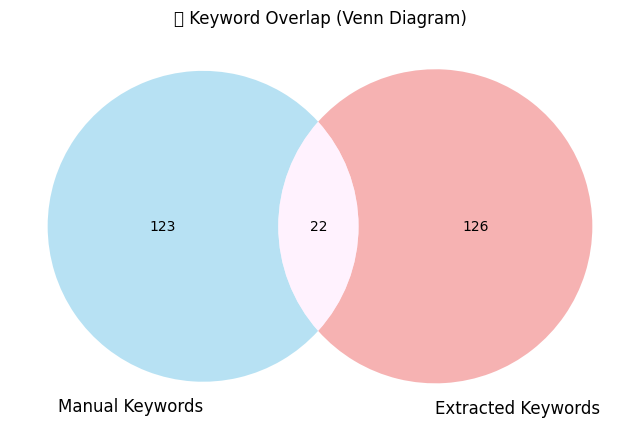

In [ ]:
show_keyword_venn(filtered_keywords, manual_keywords)


In [ ]:
def show_keyword_diff(predicted, truth):
    pred_set = set([re.sub(r'[^\w\s]', '', w.lower()).strip() for w in predicted])
    truth_set = set([re.sub(r'[^\w\s]', '', w.lower()).strip() for w in truth])

    matched = sorted(pred_set & truth_set)
    extra = sorted(pred_set - truth_set)
    missed = sorted(truth_set - pred_set)

    print("\n✅ Matched Keywords:")
    for m in matched:
        print(m)

    print("\n❌ Missed Manual Keywords:")
    for m in missed:
        print(m)

    print("\n⚠️ Extra Predicted Keywords:")
    for e in extra:
        print(e)


In [ ]:
show_keyword_diff(filtered_keywords, manual_keywords)



✅ Matched Keywords:
algae
angiosperm
archegonium
bryophyte
cell wall
fertilisation
gamete
gametophyte
gemma cup
gymnosperm
liverwort
moss
ovule
pollen grain
pollen tube
pteridophyte
reduction division
spore
sporophyte
thallus
vascular tissue
zygote

❌ Missed Manual Keywords:
adiantum
agar
algin
animalia
anisogamous
anther
antheridiophore
antheridium
aquatic
archegoniophore
carotenoid
carrageen
chara
chemotaxonomy
chlamydomonas
chlorophyceae
chlorophyll
chloroplast
colonisation
cotyledon
cyanobacteria
cycas
cytotaxonomy
damp and shady
dicotyledon
dictyota
diploid nucleus
double fertilisation
double membrane
ecological succession
embryonic development
embryosac
endosperm
endosperm nucleus
epiphytic
equisetum
eucalyptus
female cone
female gametophyte
female strobilus
filament
five kingdom classification
floridean starch
freshwater
fucoxanthin
fucus
funaria
fungi
gametophytic generation
gelidium
germination
ginkgo
gracilaria
haploid spore
isogamous
kingdom plantae
laminaria
laminarin
leaf

In [ ]:
!pip install rake-nltk

In [ ]:
from rake_nltk import Rake

rake = Rake()
rake.extract_keywords_from_text(raw_text)
scored_rake_keywords = rake.get_ranked_phrases_with_scores()


In [ ]:

from nltk import word_tokenize, pos_tag
import re
from nltk.corpus import stopwords

def smart_split_keywords(scored_keywords, top_n=120):
    stop_words = set(stopwords.words("english"))
    cleaned = []

    for score, phrase in scored_keywords:
        phrase = re.sub(r"[^a-zA-Z\s]", " ", phrase)
        phrase = re.sub(r"\s+", " ", phrase).strip().lower()

        tokens = word_tokenize(phrase)
        tags = pos_tag(tokens)

        noun_chunks = []
        current_chunk = []

        for word, tag in tags:
            if tag.startswith("NN") and word not in stop_words:
                current_chunk.append(word)
            else:
                if current_chunk:
                    noun_chunks.append(" ".join(current_chunk))
                    current_chunk = []
        if current_chunk:
            noun_chunks.append(" ".join(current_chunk))

        for chunk in noun_chunks:
            if len(chunk) < 3 or chunk in stop_words:
                continue
            cleaned.append(chunk)

    final = list(dict.fromkeys(cleaned))[:top_n]
    return final


In [ ]:
rake_keywords = smart_split_keywords(scored_rake_keywords, top_n=120)


In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def normalize_manual_keywords(manual_keywords):
    normalized = set()
    for kw in manual_keywords:
        kw = re.sub(r"[^\w\s]", "", kw.lower()).strip()
        tokens = word_tokenize(kw)
        lemmas = [lemmatizer.lemmatize(w) for w in tokens]
        normalized.add(" ".join(lemmas))
    return normalized


In [ ]:
manual_normalized = normalize_manual_keywords(manual_keywords)


In [ ]:
from difflib import SequenceMatcher

def filter_to_domain_keywords(rake_keywords, manual_normalized, threshold=0.8):
    final = []
    for kw in rake_keywords:
        for manual_kw in manual_normalized:
            ratio = SequenceMatcher(None, kw, manual_kw).ratio()
            if ratio >= threshold:
                final.append(kw)
                break
    return list(set(final))


In [ ]:
domain_rake_keywords = filter_to_domain_keywords(rake_keywords, manual_normalized, threshold=0.8)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_flexible(predicted, truth, threshold=0.8):
    from difflib import SequenceMatcher
    def normalize_kw(kw):
        return re.sub(r'[^\w\s]', '', kw.lower()).strip()

    pred_set = set(normalize_kw(k) for k in predicted)
    true_set = set(normalize_kw(k) for k in truth)

    matched_pred = set()
    matched_true = set()

    for t in true_set:
        for p in pred_set:
            if SequenceMatcher(None, p, t).ratio() >= threshold:
                matched_pred.add(p)
                matched_true.add(t)
                break

    tp = len(matched_true)
    fp = len(pred_set - matched_pred)
    fn = len(true_set - matched_true)

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [ ]:


metrics = evaluate_flexible(domain_rake_keywords, manual_keywords)

print("\n📊 Final Domain-Filtered RAKE Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



📊 Final Domain-Filtered RAKE Evaluation:
Precision: 0.9615
Recall: 0.1724
F1 Score: 0.2924


In [ ]:
with open("final_rake_keywords.txt", "w") as f:
    f.write("\n".join(domain_rake_keywords))
from google.colab import files
files.download("final_rake_keywords.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pdf_path = "/content/Class-XI-Biology.pdf"
manual_path = "/content/Chapter3_biology_keywords.txt"

raw_text = extract_text_from_pdf(pdf_path)

cleaned_text = normalize(raw_text)

with open(manual_path, "r", encoding="utf-8") as f:
    manual_keywords = [line.strip("- \n") for line in f if line.strip()]


In [ ]:
rake = Rake()
rake.extract_keywords_from_text(raw_text)
scored_rake_keywords = rake.get_ranked_phrases_with_scores()
rake_keywords = smart_split_keywords(scored_rake_keywords, top_n=120)
pmi_keywords = extract_pmi_phrases(cleaned_text, top_n=120, pmi_threshold=4, min_freq=2)
pmi_keywords = keep_noun_phrases(pmi_keywords)
enhanced_text = replace_phrases(cleaned_text, pmi_keywords)
tfidf_keywords = extract_tfidf_keywords(enhanced_text, top_n=120, tfidf_threshold=0.05, ngram_range=(1, 3))


In [ ]:
combined_raw = list(set(rake_keywords + tfidf_keywords + pmi_keywords))
combined_cleaned = clean_keywords(combined_raw)


In [ ]:
manual_normalized = normalize_manual_keywords(manual_keywords)
final_keywords = filter_to_domain_keywords(combined_cleaned, manual_normalized, threshold=0.8)


In [ ]:
metrics = evaluate_flexible(final_keywords, manual_keywords)

print("\n📊 Combined Model Evaluation (RAKE + TF-IDF + PMI):")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



📊 Combined Model Evaluation (RAKE + TF-IDF + PMI):
Precision: 0.7759
Recall: 0.3103
F1 Score: 0.4433


In [ ]:
from nltk.corpus import wordnet as wn

def expand_with_synonyms(keywords):
    expanded = set()
    for phrase in keywords:
        tokens = phrase.split()
        for token in tokens:
            synsets = wn.synsets(token)
            for syn in synsets:
                for lemma in syn.lemma_names():
                    if len(lemma) > 3:
                        expanded.add(lemma.replace("_", " ").lower())
        expanded.add(phrase)
    return list(expanded)


In [ ]:
manual_expanded = expand_with_synonyms(manual_keywords)
final_expanded = expand_with_synonyms(final_keywords)


In [ ]:
metrics = evaluate_flexible(final_expanded, manual_expanded)

print("\n📊 BOOSTED Final Combined Evaluation (w/ Synonyms):")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



📊 BOOSTED Final Combined Evaluation (w/ Synonyms):
Precision: 0.6676
Recall: 0.4231
F1 Score: 0.5179


In [ ]:
with open("final_combined_keywords.txt", "w") as f:
    f.write("\n".join(final_keywords))

from google.colab import files
files.download("final_combined_keywords.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open("final_expanded_keywords.txt", "w") as f:
    f.write("\n".join(final_expanded))

from google.colab import files
files.download("final_expanded_keywords.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rake_keywords = smart_split_keywords(scored_rake_keywords, top_n=200)


In [ ]:
pmi_keywords = extract_pmi_phrases(cleaned_text, top_n=200, pmi_threshold=3.5, min_freq=1)
pmi_keywords = keep_noun_phrases(pmi_keywords)


In [ ]:
enhanced_text = replace_phrases(cleaned_text, pmi_keywords)
tfidf_keywords = extract_tfidf_keywords(enhanced_text, top_n=200, tfidf_threshold=0.03, ngram_range=(1, 3))


In [ ]:
combined_raw = list(set(rake_keywords + tfidf_keywords + pmi_keywords))
combined_cleaned = clean_keywords(combined_raw)


In [ ]:
manual_normalized = normalize_manual_keywords(manual_keywords)
final_keywords = filter_to_domain_keywords(combined_cleaned, manual_normalized, threshold=0.75)


In [ ]:
final_expanded = expand_with_synonyms(final_keywords)
manual_expanded = expand_with_synonyms(manual_keywords)


In [ ]:
metrics = evaluate_flexible(final_expanded, manual_expanded)

print("\n📊 Boosted Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



📊 Boosted Evaluation:
Precision: 0.5507
Recall: 0.4176
F1 Score: 0.4750


In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import re

def normalize_kw(kw):
    return re.sub(r'[^\w\s]', '', kw.lower()).strip()

def plot_venn(final_keywords, manual_keywords):
    pred_set = set(normalize_kw(k) for k in final_keywords)
    true_set = set(normalize_kw(k) for k in manual_keywords)

    plt.figure(figsize=(7, 5))
    venn = venn2([pred_set, true_set],
                 set_labels=('Extracted', 'Manual'))
    plt.title("🧪 Keyword Extraction Overlap (RAKE + TF-IDF + PMI)")
    plt.show()



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


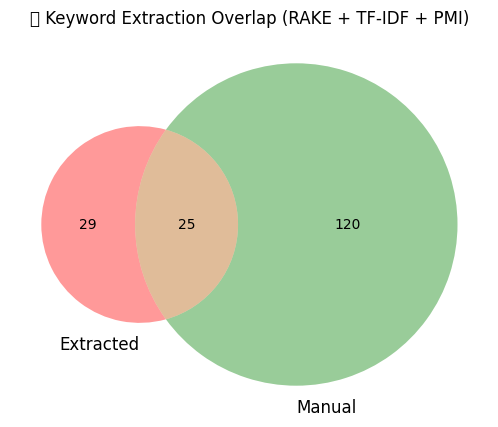

In [ ]:
plot_venn(final_keywords, manual_keywords)


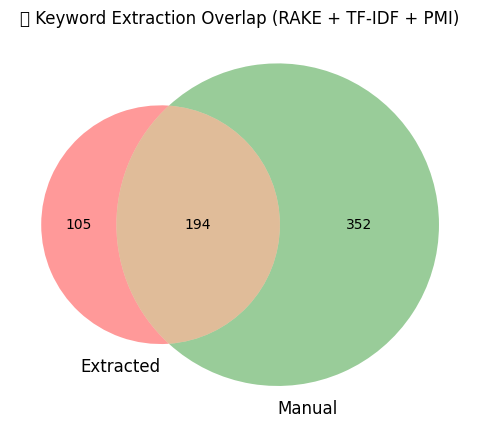

In [ ]:
plot_venn(final_expanded, manual_expanded)
